## A simple model for demand and supply of publicly-provided services in a city

In [1]:
from enum import Enum
import os.path
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import geopy, geopy.distance
import shapely
from sklearn import gaussian_process

from matplotlib import pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize']= (20,14)

In [2]:
## TODO: find way to put this into some global settings
import os
import sys
nb_dir = os.path.dirname(os.getcwd())
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg

In [3]:
from src.models.city_items import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [4]:
from src.models.services_supply import ServiceUnit, ServiceEvaluator, UnitFactory, SchoolFactory, LibraryFactory 
from src.models.services_supply import get_random_pos #TODO refactor this fun into common utils

from src.models.demand import DemandFrame
from src.models.process_tools import MappedPositionsFrame, ServiceValues, GridMaker, ValuesPlotter

In [5]:
quicktest = [ServiceUnit(ServiceType.Library, 'Duomo', ageDiffusionIn=None), 
        ServiceUnit(ServiceType.Library, 'Ripamonti', 
                    position=geopy.Point(45.43, 9.201), ageDiffusionIn=None)]
ServiceEvaluator(quicktest).evaluate_services_at(MappedPositionsFrame(get_random_pos(4)))
del quicktest

In [6]:
## Load scuole
scuoleFile =  '../data/processed/Milano_datiScuole.csv'
schoolLoader = UnitFactory.createLoader(ServiceType.School, scuoleFile)

# Initialise with a default lengthscale of 0.5 km
schoolUnits = schoolLoader.load(meanRadius=0.5)
schoolEval = ServiceEvaluator(schoolUnits)

Location data found


In [7]:
## Load biblioteche
bibliotecheFile =  '../data/processed/Milano_biblioteche.csv'
bibliotecheLoader = UnitFactory.createLoader(ServiceType.Library, bibliotecheFile)

# Initialise with a default lengthscale of 0.5 km
libraryUnits = bibliotecheLoader.load(meanRadius=0.5)

Location data found


In [8]:
# call grid making to discretise service evaluation, this is an alternative to evaluating on the demand units
milanoGridMK = GridMaker({'quartieri':'../data/raw/Milano_specific/Milano_quartieri.geojson'}, gridStep=.4)

In [9]:
#type(milanoGridMK.grid)
testEvaluator = ServiceEvaluator(schoolUnits[:10])
valuesGrid = testEvaluator.evaluate_services_at(milanoGridMK.grid)

In [10]:
from scipy.interpolate import griddata
class ValuesPlotter:
    '''
    A class that plots various types of output from ServiceValues
    '''
    def __init__(self, serviceValues, bOnGrid=False):
        assert isinstance(serviceValues, ServiceValues), 'ServiceValues class expected'
        self.values = serviceValues
        self.bOnGrid = bOnGrid
        
        
    def plot_locations(self):
        '''
        Plots the locations of the initialized ServiceValues'
        '''
        plotScales = self.ua.scale/np.mean(self.ua.scale)
        plt.figure()
        plt.scatter(self.ua.longitude, self.ua.latitude, s=plotScales)
        plt.axis('equal')
        plt.show()
        return None
    
        
    def plot_service_levels(self, servType, gridDensity=40, nLevels=50):
        '''
        Plots a contour graph of the results for each ageGroup.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        for ageGroup in self.values[servType].keys():
            
            xPlot,yPlot,z = self.values.plot_output(servType, ageGroup)
            
            if np.count_nonzero(z) > 0:
                if self.bOnGrid:
                    gridShape = (len(set(xPlot)), len(set(yPlot.flatten())))
                    assert len(xPlot) == gridShape[0]*gridShape[1], 'X values do not seem on a grid'
                    assert len(yPlot) == gridShape[0]*gridShape[1], 'Y values do not seem on a grid'
                    xi = np.array(xPlot).reshape(gridShape)
                    yi = np.array(yPlot).reshape(gridShape)
                    zi = z.reshape(gridShape)
                else:
                    # grid the data using natural neighbour interpolation
                    xi = np.linspace(min(xPlot), max(xPlot), gridDensity)
                    yi = np.linspace(min(yPlot), max(yPlot), gridDensity)
                    zi = griddata((xPlot, yPlot), z, (xi[None,:], yi[:,None]), 'linear')
                    
                plt.figure()
                plt.title(ageGroup)
                CS = plt.contourf(xi, yi, zi, nLevels)
                cbar = plt.colorbar(CS)
                cbar.ax.set_ylabel('Service level')
                plt.show()
            
        return None

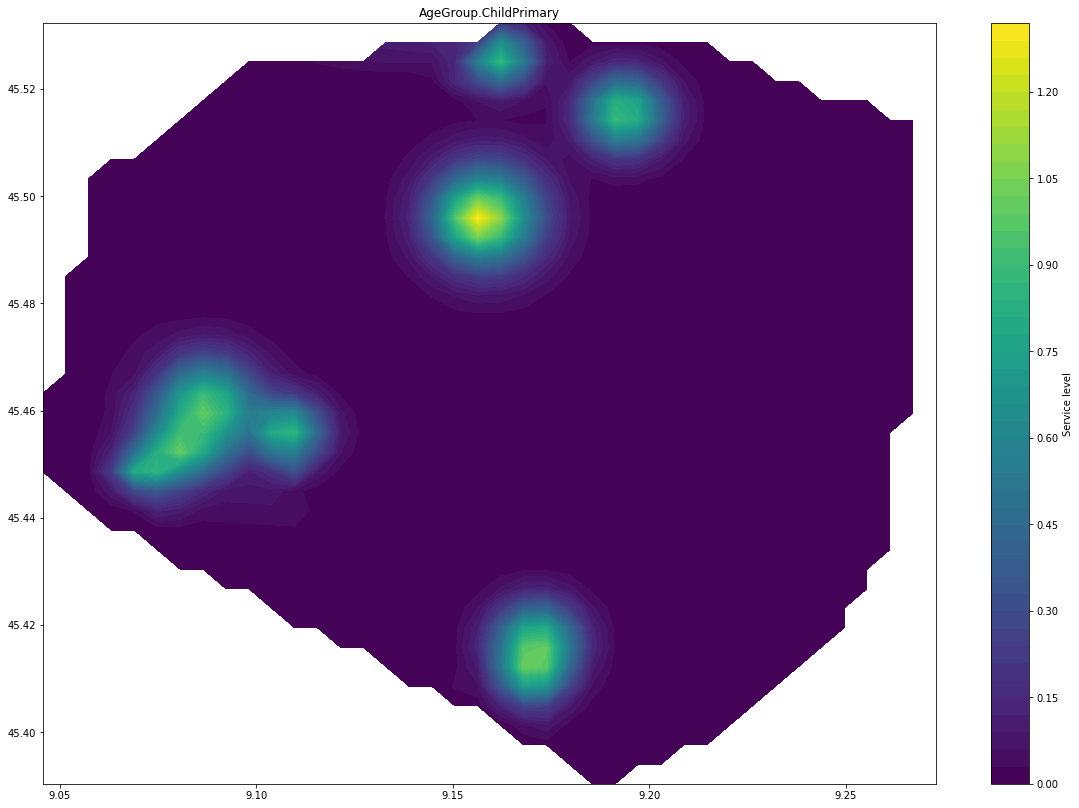

In [11]:
plotterNew = ValuesPlotter(valuesGrid)
plotterNew.plot_service_levels(ServiceType.School) # plots with griddata+contourf

In [12]:
class KPICalculator:
    '''Class to aggregate demand and evaluate section based and position based KPIs'''
    
    def __init__(self, demandFrame, serviceUnits, cityName):
        assert cityName in common_cfg.cityList, 'Unrecognized city name %s' % cityName
        assert isinstance(demandFrame, DemandFrame),'Demand frame expected'
        assert all([isinstance(su, ServiceUnit) for su in serviceUnits]),'Demand unit list expected'
        
        self.city = cityName
        self.demand = demandFrame
        self.sources = serviceUnits
        
        # initialise the service evaluator
        self.evaluator = ServiceEvaluator(serviceUnits)
        self.serviceValues = {}
        self.quartiereKPI = {}
        self.istatKPI = {}

        # derive Ages frame
        ageMIndex = [demandFrame[common_cfg.IdQuartiereColName],
                         demandFrame['Positions'].apply(tuple)]
        self.agesFrame = demandFrame[AgeGroup.all()].set_index(ageMIndex)
        self.agesTotals = self.agesFrame.groupby(level=0).sum()
        
        
    def evaluate_services_at_demand(self):
        self.serviceValues = self.evaluator.evaluate_services_at(
            self.demand.mappedPositions)
        return self.serviceValues
    
    
    def compute_kpi_for_localized_services(self):
        assert self.serviceValues, 'Service values not available, have you computed them?'
        # get mean service levels by quartiere, weighting according to the number of citizens
        for service, data in self.serviceValues.items():
            out = []
            for col in self.agesFrame.columns: # iterate over columns as Enums are not orderable...
                # TODO: introduce Demand Factors to set to NaN the cases 
                # where a service is not needed by a certain AgeGroup
                out.append(pd.Series.multiply(
                    data[col], self.agesFrame[col])/self.agesTotals[col])
                
            weightedData = pd.concat(out, axis=1)
            # sum weighted fractions and assign to output
            self.quartiereKPI[service] = weightedData.groupby(
                common_cfg.IdQuartiereColName).sum().reindex(
                columns=AgeGroup.all(), copy=False)
        
        return self.quartiereKPI
    
    
    def compute_kpi_for_istat_values(self):
        pass
    
        

In [13]:
frame = DemandFrame.create_from_istat_cpa('Milano')
demandTest = DemandFrame(frame.head(100).copy(),bDuplicatesCheck=False)
tt = KPICalculator(demandTest, schoolUnits[:10], 'Milano')
tt.evaluate_services_at_demand()
tt.compute_kpi_for_localized_services()

{<ServiceType.Library: (2, <ServiceArea.EducationCulture: 'EducazioneCultura'>, <function SummaryNorm.<lambda> at 0x7f6133b78510>, 'Biblioteche', 'MIBACT')>:              AgeGroup.Newborn  AgeGroup.Kinder  AgeGroup.ChildPrimary  \
 IDquartiere                                                             
 1                         0.0              0.0                    0.0   
 
              AgeGroup.ChildMid  AgeGroup.ChildHigh  AgeGroup.Young  \
 IDquartiere                                                          
 1                          0.0                 0.0             0.0   
 
              AgeGroup.Junior  AgeGroup.Senior  AgeGroup.Over50  \
 IDquartiere                                                      
 1                        0.0              0.0              0.0   
 
              AgeGroup.Over65  AgeGroup.Over74  
 IDquartiere                                    
 1                        0.0              0.0  ,
 <ServiceType.School: (1, <ServiceArea.EducationCultu

In [14]:
class JSONWriter:
    def __init__(self, kpiCalc):
        assert isinstance(kpiCalc, KPICalculator), 'KPI calculator is needed'
        self.layersData = kpiCalc.quartiereKPI
        self.city = kpiCalc.city
        self.areasTree = {}
        for s in self.layersData:
            area = s.serviceArea    
            self.areasTree[area] = [s] + self.areasTree.get(area, []) 

        
    def make_menu(self):
        jsonList = common_cfg.make_output_menu(
            self.city, services=list(self.layersData.keys()))
        return jsonList
        
        
    def make_serviceareas_output(self):
        out = dict()
        for area, layers in self.areasTree.items():
            layerList = []
            for service in layers:
                data = self.layersData[service]
                layerList.append(pd.Series(
                    data[AgeGroup.all()].as_matrix().tolist(),
                    index=data.index, name=service.name))
            areaData = pd.concat(layerList, axis=1).reset_index()
            out[area.value] = areaData.to_dict(orient='records')
        return out 
    
    
    def write_all_files_to_default_path(self):
        # build and write menu
        with open(os.path.join(
            '../',common_cfg.vizOutputPath, 'menu.js'), 'w') as menuFile:
            json.dump(self.make_menu(), menuFile, sort_keys=True,
                     indent=4, separators=(',', ' : '))
        
        # build and write all areas
        areasOutput = self.make_serviceareas_output()
        for name, data in areasOutput.items():
            filename =  '%s_%s.js'%(self.city,name)
            with open(os.path.join('../', common_cfg.outputPath,
                        filename), 'w') as areaFile:
                json.dump(data, areaFile, sort_keys=True,
                          indent=4, separators=(',', ' : '))
        

In [15]:
yy = JSONWriter(tt)
yy.write_all_files_to_default_path()